## Importing libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import math
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from torch.optim import Adam
from Phytopredictor import PhytoPredictor, aggregate_phyto_data, extrapolate, train_phytopredictor

In [2]:
df = pd.read_excel('../../data/MERGED_DATA_180624.xlsx', sheet_name='MERGE_FINAL')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


## Defining the different columns and preparing the dataframe

In [3]:

columns = list(df.columns)

abio_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']
phyto_columns = ['Acn', 'Aco', 'Agl', 'Ata', 'Cau', 'Ccu', 'Cda',
       'Cdeb', 'Cden', 'Cdi', 'Cei', 'Cfu', 'Cgr', 'Cha', 'Coc', 'Cra', 'Csu',
       'Cwa', 'Dac', 'Dat', 'Dbr', 'Dip', 'Dle', 'Dno', 'Dpu', 'Dro', 'Dsp',
       'Edu', 'Etr', 'Ezo', 'Fja', 'Gde', 'Gfa', 'Gfl', 'Gsp', 'Hak', 'Hta',
       'Kgl', 'Lan', 'Lun', 'Mhe', 'Mnu', 'Mpe', 'Ndi', 'Nsc', 'Nsi', 'Oau',
       'Omo', 'Ore', 'Orh', 'Oro', 'Osi', 'Pac', 'Pan', 'Pba', 'Pbi', 'Pbr',
       'Pcl', 'Pco', 'Pde', 'Pha', 'Plo', 'Pmi', 'Pos', 'Pse', 'Pst', 'Psu',
       'Pte', 'Ptr', 'Ram', 'Rse', 'Rst', 'Rte', 'Stu', 'Tec', 'Tle', 'Tni',
       'Tno', 'Tor', 'Tro']
loc_date_columns = ["LOC_CODE", "DATUM"]

ignored_columns = set(df.columns) - set(loc_date_columns + abio_columns + phyto_columns)

df = df.drop(list(ignored_columns), axis=1)
df[phyto_columns] = df[phyto_columns].applymap(lambda x: 10**x)

# a subset of the abio columns
abio_columns = ['T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NH4 [umol/L]']

clusters = [['Agl', 'Dbr', 'Ezo', 'Gde', 'Osi', 'Rse', 'Tni', 'Tro', 'Dle', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pha', 'Stu', 'Oro', 'Cdi', 'Cra', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Pco', 'Cdeb', 'Cwa', 'Ptr', 'Tno', 'Ccu', 'Pan', 'Psu', 'Cei', 'Cda', 'Cha', 'Plo', 'Dpu', 'Fja', 'Hak'],
['Ram', 'Tec', 'Csu', 'Acn'],
['Pbr', 'Kgl', 'Tor', 'Ata', 'Cfu', 'Pba', 'Dac', 'Nsi', 'Rst', 'Pst', 'Dsp', 'Ndi', 'Dro', 'Cau', 'Coc', 'Pte', 'Mpe', 'Pde', 'Rte', 'Dno'],
['Dip', 'Mnu', 'Gfa'],
['Oau', 'Omo', 'Orh', 'Tle', 'Etr', 'Ore', 'Lun', 'Hta', 'Pac', 'Edu', 'Mhe']]

# clusters = [['Agl', 'Dbr', 'Ezo', 'Gde', 'Osi', 'Rse', 'Tni', 'Tro', 'Dle', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pha', 'Stu', 'Oro', 'Cdi', 'Cra', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Pco', 'Cdeb', 'Cwa', 'Ptr', 'Tno', 'Ccu', 'Pan', 'Psu', 'Cei', 'Cda', 'Cha', 'Plo', 'Dpu', 'Fja', 'Hak']]


## Aggregating the dataset using the clusterings

In [4]:
grouped_phyto_df, group_labels = aggregate_phyto_data(df, clusters, fill_methods=["linear_interpolate", "backward_fill"])

grouped_phyto_df[group_labels] = grouped_phyto_df[group_labels].applymap(lambda x: math.log10(x))

grouped_phyto_df.head()


,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l],Dat,group_0,group_1,group_2,group_3,group_4
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2,NaN,5.984462,4.371265,4.576128,3.115943,4.689914


## Splitting the Dataframe for each Location

In [5]:
scaler = StandardScaler()

grouped_phyto_df[abio_columns] = scaler.fit_transform(grouped_phyto_df[abio_columns])

grouped_phyto_df[group_labels] = scaler.fit_transform(grouped_phyto_df[group_labels])

location_groups = grouped_phyto_df.groupby("LOC_CODE")

location_data_dict = {}
for name, loc_df in location_groups:
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1).reset_index()
    
    location_data_dict[name] = loc_df

for key, value in location_data_dict.items():
    print(f"{key}: {value.shape}")

DANTZGT: (598, 18)
DREISR: (584, 18)
GOERE6: (374, 18)
GROOTGND: (588, 18)
HANSWGL: (589, 18)
HUIBGOT: (588, 18)
LODSGT: (584, 18)
MARSDND: (590, 18)
NOORDWK10: (918, 18)
NOORDWK2: (580, 18)
NOORDWK20: (550, 18)
NOORDWK70: (550, 18)
ROTTMPT3: (289, 18)
ROTTMPT50: (210, 18)
ROTTMPT70: (210, 18)
SCHAARVODDL: (816, 18)
SOELKKPDOT: (584, 18)
TERSLG10: (542, 18)
TERSLG100: (461, 18)
TERSLG135: (462, 18)
TERSLG175: (373, 18)
TERSLG235: (372, 18)
TERSLG4: (288, 18)
VLISSGBISSVH: (690, 18)
WALCRN2: (373, 18)
WALCRN20: (371, 18)
WALCRN70: (371, 18)


## Defining some helper functions

In [6]:
# ty chatgpt for this ez function :)
def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# simple function for plotting the losses
def plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100):
    training_loss_log_np = [loss.detach().numpy() for loss in training_loss_log]

    smoothed_training_loss = moving_average(training_loss_log_np, window_size)

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    _ = axs[0].plot(np.arange(len(training_loss_log_np)), training_loss_log_np)
    _ = axs[0].set_xlabel('Steps')
    _ = axs[0].set_ylabel('Training Loss')
    _ = axs[1].plot(np.arange(len(smoothed_training_loss)), smoothed_training_loss)
    _ = axs[1].set_xlabel('Steps')
    _ = axs[1].set_ylabel('Smoothed Training Loss')
    _ = axs[2].plot(np.arange(len(evaluation_loss_log)) * check_interval, evaluation_loss_log)
    _ = axs[2].set_xlabel('Steps')
    _ = axs[2].set_ylabel('Validation Loss')
    _ = axs[3].plot(np.arange(len(percentage_error_log)) * check_interval, percentage_error_log)
    _ = axs[3].set_xlabel('Steps')
    _ = axs[3].set_ylabel('Percentage Error')

    _ = fig.tight_layout(h_pad=2, w_pad=2)

    print("Last training loss: ", training_loss_log_np[-1])
    print("Last evaluation loss: ", evaluation_loss_log[-1])
    print("Last percentage error: ", percentage_error_log[-1])

    plt.show()

### Optimise the parameters with Grid Search


In [7]:
import itertools

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
output_size = input_size_phyto

trial_name = "Optimal_Parameter_Test"
shuffled_rows = True
random_seed = 2
minimum_lookback = 10
loss_metric = "MSE"
check_interval = 10

# define the hyperparameter grid
param_grid = {
    'lstm_hidden_size': [len(clusters) - 1, len(clusters), len(clusters) + 1],
    'ffnn_hidden_size': [max(input_size_abio - 3, 5) - 1, max(input_size_abio - 3, 5)],
    'p_drop': [0.1, 0.3],
    'lr': [0.0001, 0.001, 0.01],
    'lookback': [10, 50, -1]
}

# generate all combinations of hyperparameters
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]


In [8]:
epochs = 10
data = location_data_dict["DANTZGT"]

def train_and_evaluate(params):
    # Create model and optimizer with the given hyperparameters
    model = PhytoPredictor(input_size_phyto, params["lstm_hidden_size"], input_size_abio, 
                           params["ffnn_hidden_size"], output_size, params['p_drop'], 
                           False)
    optimizer = Adam(model.parameters(), lr=params['lr'])
    
    # Train the model
    model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(
        model, optimizer, data, trial_name, abio_columns, group_labels, shuffled_rows,
        random_seed, 0.7, minimum_lookback, params['lookback'], 
        loss_metric, device, epochs, check_interval, no_print=True
    )
    
    # Evaluate the model
    evaluation_loss = evaluation_loss_log[-1]  # Assuming the last value is the evaluation loss
    
    return evaluation_loss

# Initialize variables to store the best hyperparameters and the corresponding loss
best_params = None
best_loss = float('inf')

# # Iterate over all combinations of hyperparameters
# for i, params in enumerate(combinations):
#     print(f"Testing ({i}/{len(combinations)}) combination: {params}")
#     evaluation_loss = train_and_evaluate(params)
    
#     if evaluation_loss < best_loss:
#         best_loss = evaluation_loss
#         best_params = params

print("\n\n\n------------GRID SEARCH DONE------------")
print("Best hyperparameters found:")
print(best_params)
print(f"Validation Loss: {best_loss}")





------------GRID SEARCH DONE------------
Best hyperparameters found:
None
Validation Loss: inf


## Run training with optimized parameters

PhytoPredictor(
  (history_encoder): LSTM(5, 6)
  (simple_history_encoder): RNN(5, 6)
  (FFNN): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=12, out_features=5, bias=True)
  )
)


  0%|          | 0/1460 [00:00<?, ?it/s]

Last training loss:  0.90539217
Last evaluation loss:  tensor(0.2555)
Last percentage error:  tensor([  5.1713,  48.3560, -55.2612,  19.7078,  38.5685])


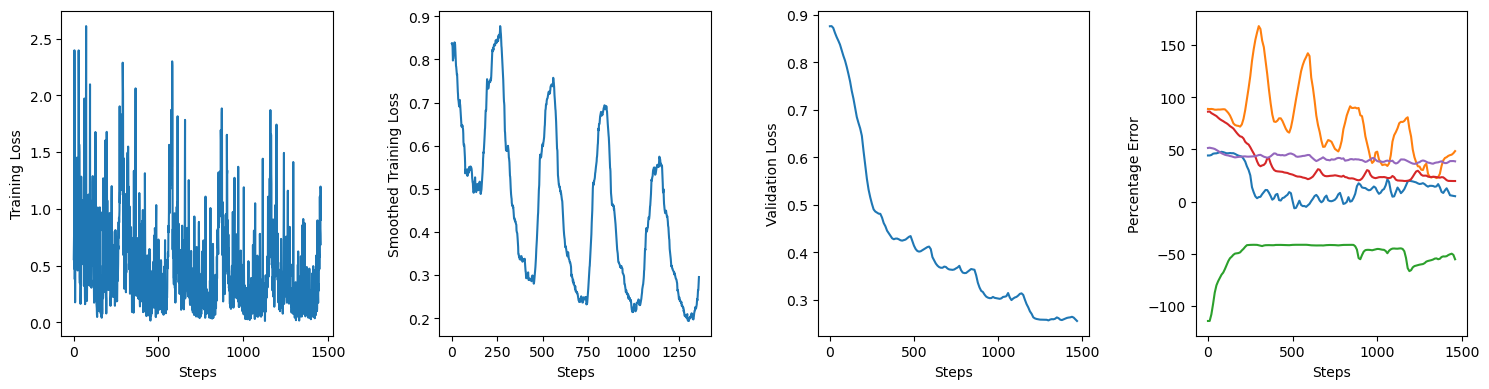

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
lstm_hidden_size = input_size_phyto + 1
ffnn_hidden_size = max(input_size_abio - 3, 5) - 1
output_size = input_size_phyto
p_drop = 0.2
bidirectional = False

trial_name = "Optimal_Parameter_Test"
shuffled_rows = True
random_seed = 2
train_ratio = 0.7
minimum_lookback = 10
lookback = 150
loss_metric = "MSE"
lr = 0.001
epochs = 5
check_interval = 10

# for now we just train for DANTZGT
data = location_data_dict["DANTZGT"]

training_part = int(len(data) * 0.7)

test_data = data.iloc[training_part:]
data = data.iloc[:training_part]

model = PhytoPredictor(input_size_phyto, lstm_hidden_size, input_size_abio, ffnn_hidden_size, output_size, p_drop, bidirectional)

# optimiser is Adam for now, but can be changed
optimiser = Adam(model.parameters(), lr=lr)

model, training_loss_log, evaluation_loss_log, percentage_error_log, predictions, real_values = train_phytopredictor(model, 
                                                                     optimiser, 
                                                                     data, 
                                                                     trial_name, 
                                                                     abio_columns, 
                                                                     group_labels, 
                                                                     shuffled_rows, 
                                                                     random_seed, 
                                                                     train_ratio, 
                                                                     minimum_lookback, 
                                                                     lookback, 
                                                                     loss_metric,
                                                                     device,
                                                                     epochs,
                                                                     check_interval)


plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100)

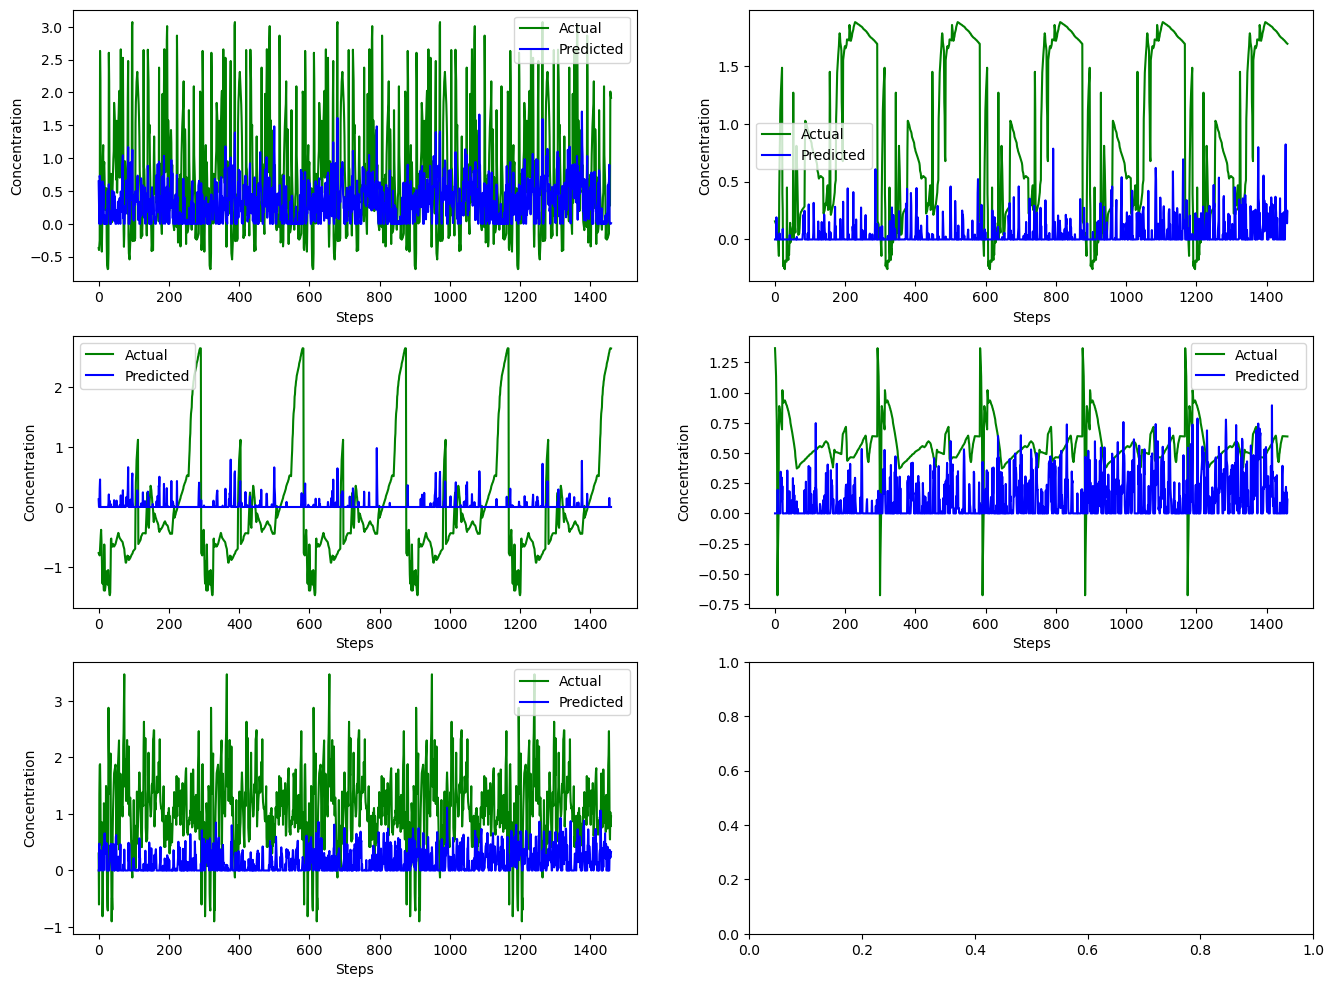

In [24]:
colcount = 2

rowcount = int(math.ceil(len(group_labels) / colcount))

fig, ax = plt.subplots(rowcount, colcount, 
                figsize=(8 * colcount, 4 * rowcount))

predictions_np = np.asarray(predictions)
real_values_np = np.asarray(real_values)

for i, column in enumerate(group_labels):

    prediction_column = predictions_np[:, i]
    real_column = real_values_np[:, i]

    if colcount == 1:
        subplot = ax[i // colcount]
    elif rowcount == 1:
        subplot = ax[i % colcount]
    else:
        subplot = ax[i // colcount][i % colcount]
    
    cycle_len = len(prediction_column)

    subplot.plot(range(cycle_len), real_column, 'g', label="Actual")
    subplot.plot(range(cycle_len), prediction_column, 'b', label="Predicted")
    
    subplot.set_xlabel('Steps')
    subplot.set_ylabel('Concentration')
    subplot.legend()
    # subplot.set_title(column)

## Phytoplankton Concentration Extrapolation

Extrapolating... (418/180)
Extrapolating... (419/180)
Extrapolating... (420/180)
Extrapolating... (421/180)
Extrapolating... (422/180)
Extrapolating... (423/180)
Extrapolating... (424/180)
Extrapolating... (425/180)
Extrapolating... (426/180)
Extrapolating... (427/180)
Extrapolating... (428/180)
Extrapolating... (429/180)
Extrapolating... (430/180)
Extrapolating... (431/180)
Extrapolating... (432/180)
Extrapolating... (433/180)
Extrapolating... (434/180)
Extrapolating... (435/180)
Extrapolating... (436/180)
Extrapolating... (437/180)
Extrapolating... (438/180)
Extrapolating... (439/180)
Extrapolating... (440/180)
Extrapolating... (441/180)
Extrapolating... (442/180)
Extrapolating... (443/180)
Extrapolating... (444/180)
Extrapolating... (445/180)
Extrapolating... (446/180)
Extrapolating... (447/180)
Extrapolating... (448/180)
Extrapolating... (449/180)
Extrapolating... (450/180)
Extrapolating... (451/180)
Extrapolating... (452/180)
Extrapolating... (453/180)
Extrapolating... (454/180)
E

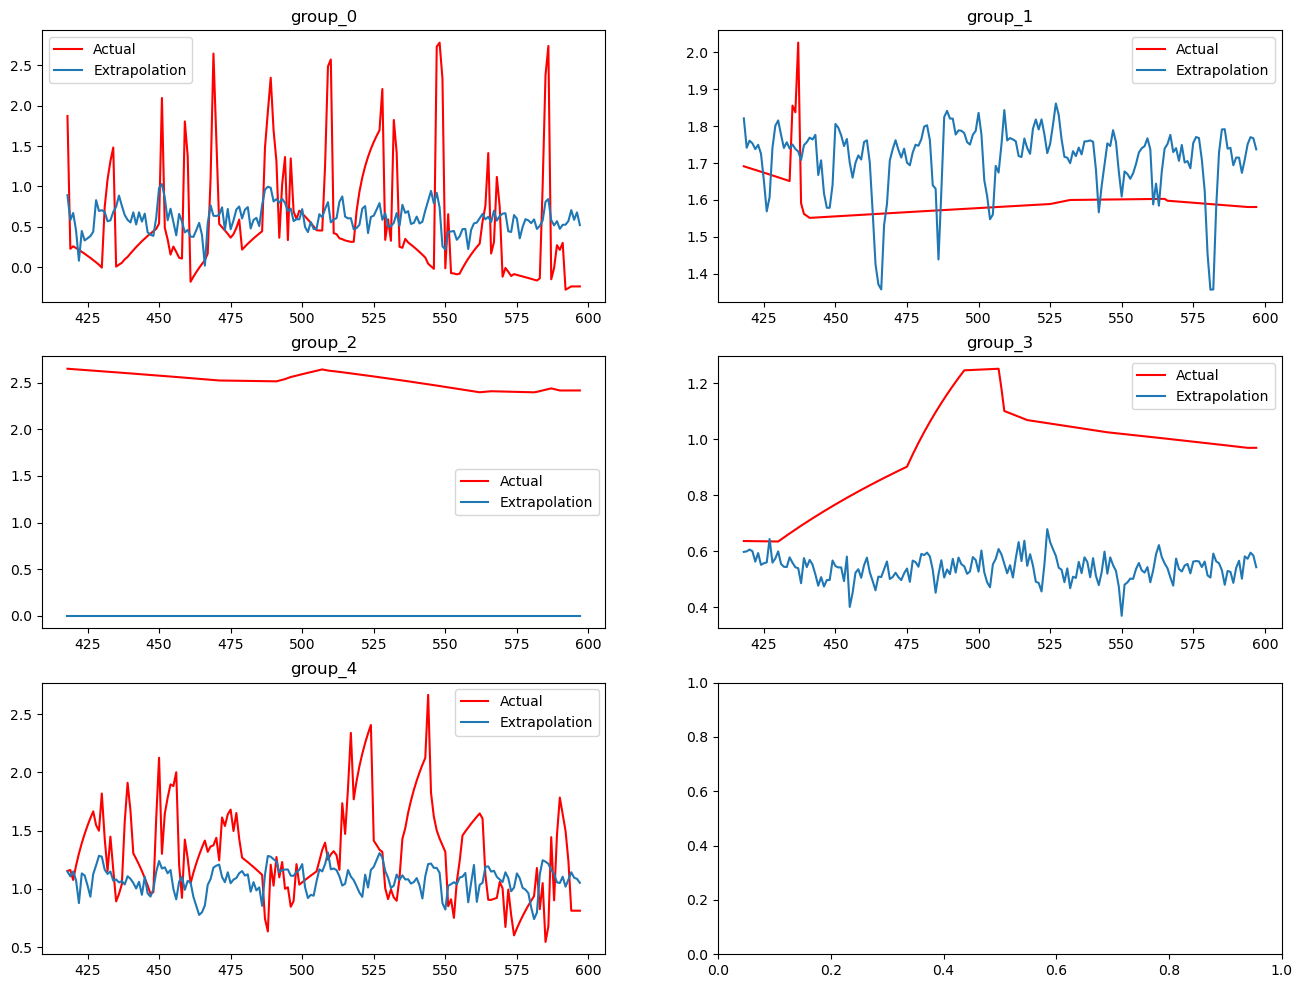

In [21]:
# abiotic_data = pd.read_csv("DANTZGT_abio_extrapolate_48.csv")
abiotic_data = test_data[abio_columns]

phytoplankton_history = data[group_labels]

extrapolated_data, abio_test = extrapolate(model, abiotic_data, phytoplankton_history, device)

print(extrapolated_data.shape)
print(phytoplankton_history.shape)
print(test_data.shape)

colcount = 2

rowcount = int(math.ceil(len(group_labels) / colcount))

fig, ax = plt.subplots(rowcount, colcount, 
                figsize=(8 * colcount, 4 * rowcount))

for i, column in enumerate(group_labels):

    extrapolated_column = extrapolated_data[:, i]

    if colcount == 1:
        subplot = ax[i // colcount]
    elif rowcount == 1:
        subplot = ax[i % colcount]
    else:
        subplot = ax[i // colcount][i % colcount]
    
    hist_length = len(phytoplankton_history[column])

    # subplot.plot(range(hist_length), phytoplankton_history[column], 'g', label="History")
    subplot.plot(range(hist_length, hist_length + len(test_data)), test_data[column], 'r', label="Actual")

    subplot.plot(range(hist_length, hist_length + len(extrapolated_column)), extrapolated_column, label="Extrapolation")
    subplot.legend()
    subplot.set_title(column)